   INFO | len(ring)=441 | ipykernel_16264.4023037093


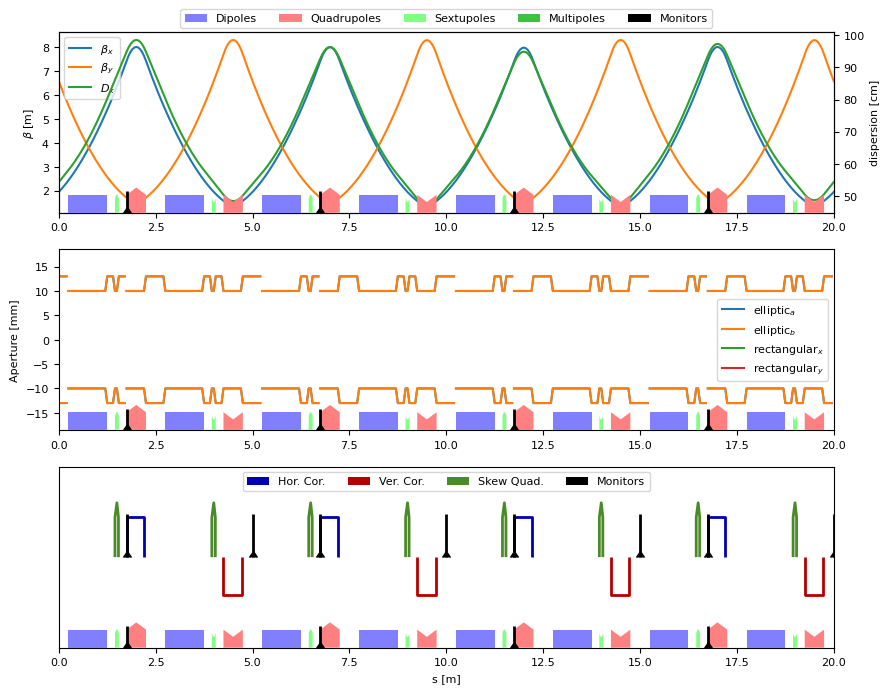

   INFO | Circumference error applied. | core.simulated_commissioning
   INFO | Calculating model response matrix | lattice_properties.response_model


C:\Users\musa\PycharmProjects2\pySC\pySC\plotting\plot_lattice.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


   INFO | Calculating model dispersion | lattice_properties.response_model
Calculating Measure response matrix


In [2]:
import at
from pySC.core.simulated_commissioning import SimulatedCommissioning
from pySC.utils.sc_tools import SCgetOrds
from pySC.plotting.plot_lattice import plot_lattice
from pySC.utils import logging_tools
from pySC.correction.loco_modules import *
from matplotlib import pyplot as plt

LOGGER = logging_tools.get_logger(__name__)

def create_at_lattice() -> Lattice:
    def _marker(name):
        return at.Marker(name, PassMethod='IdentityPass')
    qf = at.Quadrupole('QF', 0.5, 1.2, PassMethod='StrMPoleSymplectic4RadPass')
    qd = at.Quadrupole('QD', 0.5, -1.2, PassMethod='StrMPoleSymplectic4RadPass')
    sf = at.Sextupole('SF', 0.1, 6.0487, PassMethod='StrMPoleSymplectic4RadPass')
    sd = at.Sextupole('SD', 0.1, -9.5203, PassMethod='StrMPoleSymplectic4RadPass')
    bend = at.Bend('BEND', 1, 2 * np.pi / 40, PassMethod='BndMPoleSymplectic4RadPass')
    d2 = at.Drift('Drift', 0.25)
    d3 = at.Drift('Drift', 0.2)
    BPM= at.Monitor('BPM')

    cell = at.Lattice([d2, _marker('SectionStart'), _marker('GirderStart'), bend, d3, sf, d3, _marker('GirderEnd'),
                       _marker('GirderStart'), BPM, qf, d2, d2, bend, d3, sd, d3, qd, d2, _marker('BPM'),
                       _marker('GirderEnd'), _marker('SectionEnd')], name='Simple FODO cell', energy=2.5E9)
    new_ring = at.Lattice(cell * 20)
    rfc = at.RFCavity('RFCav', energy=2.5E9, voltage=2e6, frequency=500653404.8599995, harmonic_number=167, length=0)
    new_ring.insert(0, rfc)
    new_ring.enable_6d()
    at.set_cavity_phase(new_ring)
    at.set_rf_frequency(new_ring)
    new_ring.tapering(niter=3, quadrupole=True, sextupole=True)

    return new_ring




if __name__ == "__main__":
    ring = at.Lattice(create_at_lattice())
    LOGGER.info(f"{len(ring)=}")
    SC = SimulatedCommissioning(ring)
    ords = SCgetOrds(SC.RING, 'BPM')
    SC.register_bpms(ords,
                     Roll=0.0, CalError=5E-2 * np.ones(2) , NoiseCO=1E-6 * np.ones(2))#, CalError=5E-2 * np.ones(2))
    ords = SCgetOrds(SC.RING, 'QF')
    SC.register_magnets(ords, HCM=1E-3,
                        CalErrorB=np.array([5E-2, 1E-3])) #10E-30
    ords = SCgetOrds(SC.RING, 'QD')
    SC.register_magnets(ords, VCM=1E-3,CalErrorA=np.array([5E-2, 0]),
                        CalErrorB=np.array([0, 1E-3]))
    ords = SCgetOrds(SC.RING, 'BEND')
    SC.register_magnets(ords)
    ords = SCgetOrds(SC.RING, 'SF|SD')
    SC.register_magnets(ords,
                        SkewQuad=0.1)
    ords = SCgetOrds(SC.RING, 'RFCav')
    SC.register_cavities(ords)
    ords = np.vstack((SCgetOrds(SC.RING, 'GirderStart'), SCgetOrds(SC.RING, 'GirderEnd')))
    SC.register_supports(ords, "Girder"),
    ords = np.vstack((SCgetOrds(SC.RING, 'SectionStart'), SCgetOrds(SC.RING, 'SectionEnd')))
    SC.register_supports(ords, "Section")
    SC.INJ.beamSize = np.diag(np.array([200E-6, 100E-6, 100E-6, 50E-6, 1E-3, 1E-4]) ** 2)
    for ord in SCgetOrds(SC.RING, 'Drift'):
        SC.RING[ord].EApertures = 13E-3 * np.array([1, 1])
    for ord in SCgetOrds(SC.RING, 'QF|QD|BEND|SF|SD'):
        SC.RING[ord].EApertures = 10E-3 * np.array([1, 1])
    SC.RING[SC.ORD.Magnet[50]].EApertures = np.array([6E-3, 3E-3])
    plot_lattice(SC, s_range=np.array([0, 20]))
    SC.apply_errors()


    CorOrds = SC.ORD.CM
    CAVords = SCgetOrds(SC.RING, 'RFC')
    quadsOrds = [SCgetOrds(SC.RING, 'QF'), SCgetOrds(SC.RING, 'QD')]
    CAVords = SCgetOrds(SC.RING, 'RFCav')
    sextOrds = SCgetOrds(SC.RING, 'SF|SD')
    skewOrds =  SC.ORD.SkewQuad
    CMstep =  1.e-4 #correctors change [rad]
    dk = 1.e-4 #quads change
    RFstep = 1e3

    orbit_response_matrix_model = SCgetModelRM(SC, SC.ORD.BPM, CorOrds, trackMode='ORB', useIdealRing=True, dkick= CMstep)
    ModelDispersion = SCgetModelDispersion(SC, SC.ORD.BPM, CAVords, trackMode='ORB', Z0=np.zeros(6), nTurns=1, rfStep=RFstep, useIdealRing=True)

    J =   generatingJacobian(SC, orbit_response_matrix_model, CMstep, CorOrds, SC.ORD.BPM, np.concatenate(quadsOrds), dk, debug=True, trackMode='ORB', useIdealRing=False,skewness = False, order=1, method='add', includeDispersion=False, rf_step=RFstep, cav_ords=CAVords, full_jacobian = True )

    errq =[]
    for i in np.concatenate(quadsOrds):
        errq.append(SC.RING[i].K- SC.IDEALRING[i].K)

    err_cor=[]
    for i in CorOrds[0]:
        err_cor.append(SC.RING[i].CalErrorB[0])
    for i in CorOrds[1]:
        err_cor.append(SC.RING[i].CalErrorA[0])
    orbit_response_matrix_measured = SCgetMeasurRM(SC, SC.ORD.BPM, CorOrds, CMstep)

    sigma = np.full(len(SC.ORD.BPM) *2, 1)
    W = np.diag(1 / (sigma ** 2))

    err_bpms=[]
    for i in SC.ORD.BPM:
        err_bpms.append(SC.RING[i].CalError[0])
    for i in SC.ORD.BPM:
        err_bpms.append(SC.RING[i].CalError[1])


    SC.INJ.trackMode = 'ORB'
    bpm_nois, b = bpm_reading(SC, SC.ORD.BPM, calculate_errors=True) #Only for tests

    sigma1 =[]
    for i in range(len(SC.ORD.BPM)):
        sigma1.append(bpm_nois[1][i])
    for i in range(len(SC.ORD.BPM)):
        sigma1.append(bpm_nois[1][i])
    sigma_ = np.array(sigma1)

    min_value = np.min(abs(sigma_))
    sigma_ /= min_value
    sigma = sigma_

    W = 1/sigma
    W = np.diag(1 / (sigma)** 2)

In [9]:
print('LOCO correction')

initial_guess = np.zeros(len(np.concatenate(quadsOrds)) + len(np.concatenate(CorOrds)) +  len(SC.ORD.BPM) *2)
initial_guess[0:len(np.concatenate(quadsOrds))] = 1e-6
initial_guess[len(np.concatenate(quadsOrds)):len(np.concatenate(quadsOrds)) + len(np.concatenate(CorOrds))] = 1e-6
initial_guess[len(np.concatenate(quadsOrds)) + len(np.concatenate(CorOrds)):] = 1e-6
lengths = [len(np.concatenate(quadsOrds)),len(np.concatenate(CorOrds)),  len(SC.ORD.BPM) *2]
including_fit_parameters = ['quads', 'cor', 'bpm']

fit_parameters, params_to_check  = loco_correction(lambda delta_params: objective(delta_params, orbit_response_matrix_model, orbit_response_matrix_measured, J, lengths, including_fit_parameters, W),initial_guess,orbit_response_matrix_model, orbit_response_matrix_measured, J, lengths,including_fit_parameters,W,verbose=2)

dg  = fit_parameters.x[0:len(np.concatenate(quadsOrds))]
dx = fit_parameters.x[len(np.concatenate(quadsOrds)):len(np.concatenate(quadsOrds)) + len(np.concatenate(CorOrds))]
dy = fit_parameters.x[len(np.concatenate(quadsOrds)) + len(np.concatenate(CorOrds)):]
print('Fit result:', params_to_check, 'Cost function:', fit_parameters.cost)

LOCO correction
`ftol` termination condition is satisfied.
Function evaluations 1772, initial cost 2.5196e+00, final cost 1.2290e-02, first-order optimality 7.67e-06.
Fit result: {'r_squared': 0.9998189565968705, 'rmse': 0.033668641105301426} Cost function: 0.012289832277891937
